## Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import datetime as dt
import seaborn as sns
import math
import random

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

from pandas.plotting import autocorrelation_plot

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools as sts
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import scipy.stats
import pylab

from utils import *
from pulp import *

## Promotion Planning in Pharma Supply Chains

**Boğaziçi University**<br>
**Department of Industrial Engineering**<br>
IE492 - Graduation Project<br>
10.12.2023<br>

**Contributors**<br>
Ahmet Yiğit Doğan 2018402105<br>
Yasin Seçal 2018402135<br>
Barış Arslan 2019402129<br>

**Advisors**<br>
Prof. Dr. Taner Bilgiç<br>
Prof. Dr. Mustafa Gökçe Baydoğan<br>

## 1. Project Description

In this project transaction data from a pharmaceutical supply chain will be used in order to understand the basic dynamics of the industry. On the basis of data analysis, efficient prediction methods will be designed and promotion strategies will be recommended.

## 2. Data Analysis

In [2]:
sales_data = pd.read_parquet("sale_data.parquet")
promo_data = pd.read_excel("promo_data.xlsx")

df_sales = pd.DataFrame(sales_data)
df_promo = pd.DataFrame(promo_data)

df_sales['Date'] = pd.to_datetime(df_sales['Date']).dt.date

df_sales.head()

,Date,LocationId,MainDistributorId,DistributorId,PackageId,ProductId,City,District,BrickId,PaidQty,FreeQty
0,2023-01-02,2873114,2879223,2878715,615,38,Kütahya,MERKEZ,430002,24,12
1,2023-01-16,2872993,2879223,2878715,615,38,Kütahya,ALTINTAŞ,430101,7,3
2,2023-01-18,2918671,2879223,2878715,615,38,Afyon,MERKEZ,30002,7,3
3,2023-01-19,2919833,2879223,2878715,615,38,Uşak,MERKEZ,640001,7,3
4,2023-01-02,2873114,2879223,2878715,616,38,Kütahya,MERKEZ,430002,24,12


In [3]:
df_promo.head()

,MProductId,BeginDate,EndDate,PaidQty,FreeQty
0,14,2022-01-01,2022-01-31 23:30:00,6,2
1,14,2022-01-01,2022-01-31 23:30:00,12,5
2,14,2022-01-01,2022-01-31 23:30:00,24,12
3,14,2022-02-01,2022-02-28 23:30:00,6,2
4,14,2022-02-01,2022-02-28 23:30:00,12,5


### 2.1. Merged Dataset (Sales Data + Promotion Data)

In [4]:
df = pd.read_parquet("Sales_Data_v2.parquet")
df["TotalQty"] = df["PaidQty"] + df["FreeQty"]
df.head()

,Date,LocationId,MainDistributorId,DistributorId,PackageId,ProductId,City,District,BrickId,PaidQty,FreeQty,isPromoted,Discount,BeginDate,EndDate,Promo,DStep,WeekStartDate,TotalQty
0,2023-01-02,2854453,2879223,2878715,568,29,Afyon,DİNAR,30601,10,0,0,0.0,NaT,NaT,None,0.0,2023-01-02,10
1,2022-06-29,2867763,2879249,2878795,568,29,Gaziantep,ŞEHİTKAMİL,270202,15,0,0,0.0,NaT,NaT,None,0.0,2022-06-27,15
2,2023-01-04,2877675,2879223,2878715,568,29,Uşak,BANAZ,640101,3,0,0,0.0,NaT,NaT,None,0.0,2023-01-02,3
3,2022-06-29,2918985,2879249,2878795,568,29,Şanlıurfa,HALİLİYE,630001,15,0,0,0.0,NaT,NaT,None,0.0,2022-06-27,15
4,2023-01-04,2854545,2879223,2878715,568,29,Afyon,MERKEZ,30001,20,0,0,0.0,NaT,NaT,None,0.0,2023-01-02,20


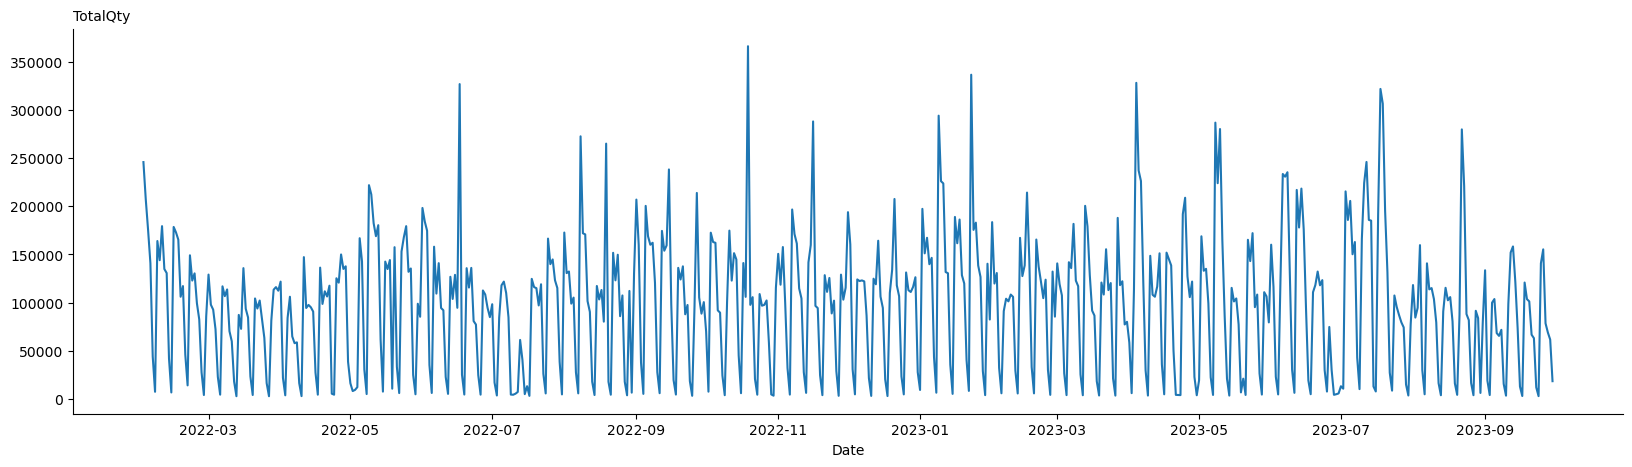

In [5]:
sales = df
sales = sales.groupby([sales['Date'].dt.date])['TotalQty'].sum()
sales.plot(figsize=(20,5), title="TotalQty")
plt.show()

## 3. Demand Forecasting

### 3.1. Forecasting Model 1

No aggregation, all products, single predictor (Free Quantity)

In [6]:
fit = smf.ols('TotalQty ~ FreeQty', df).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.565
Method:                 Least Squares   F-statistic:                 1.158e+07
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:04:26   Log-Likelihood:            -3.2987e+07
No. Observations:             8931111   AIC:                         6.597e+07
Df Residuals:                 8931109   BIC:                         6.597e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.1531      0.003   1570.571      0.000       5.147       5.160
FreeQty        2.6839      0.001   3402.640      0.000       2.682       2.685
==============================================================================
Omnibus:                 25864001.967   Durbin-Watson:                   1.684
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   18404874264009.602
Skew:                          38.759   Prob(JB):                         0.00
Kurtosis:                    7035.228   Cond. No.                         4.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

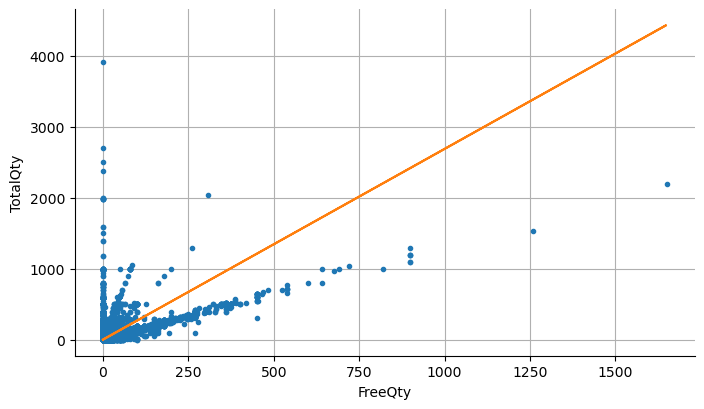

In [7]:
fig, ax = plt.subplots()
ax.plot(df.FreeQty, df.PaidQty, '.')
ax.plot(df.FreeQty, fit.predict())
ax.set(ylabel="TotalQty", xlabel="FreeQty")
ax.grid()

### 3.2. Forecasting Model 2

No aggregation, all products, multiple predictors (Free Quantity, is Promoted, Discount Ratio)

In [8]:
fit = smf.ols('TotalQty ~ FreeQty + isPromoted + Discount', df).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                 4.783e+06
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:04:33   Log-Likelihood:            -3.2421e+07
No. Observations:             8931111   AIC:                         6.484e+07
Df Residuals:                 8931107   BIC:                         6.484e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3427      0.003   1300.469      0.000       4.336       4.349
FreeQty        2.7883      0.001   3395.149      0.000       2.787       2.790
isPromoted    16.4981      0.015   1098.697      0.000      16.469      16.528
Discount     -69.7688      0.077   -901.883      0.000     -69.920     -69.617
==============================================================================
Omnibus:                 27281386.926   Durbin-Watson:                   1.732
Prob(Omnibus):                  0.000   Jarque-Bera (JB):   30288662149571.605
Skew:                          44.974   Prob(JB):                         0.00
Kurtosis:                    9024.346   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3.3. Forecasting Model 3

Daily aggregation, all products, multiple predictors (Free Quantity, weekday)

In [9]:
df_prod = df
df_prod = df_prod.groupby([df_prod['Date'].dt.date, df_prod["ProductId"]])[["TotalQty", "FreeQty"]].sum()
df_prod = df_prod.reset_index()

df_prod = df_prod.assign(
    weekday = df_prod.Date.apply(lambda x: x.weekday()),
    index = np.arange(len(df_prod)))

df_prod

,Date,ProductId,TotalQty,FreeQty,weekday,index
0,2022-02-01,14,4911,1117,1,0
1,2022-02-01,15,29604,9,1,1
2,2022-02-01,16,8034,1709,1,2
3,2022-02-01,20,25184,991,1,3
4,2022-02-01,21,19689,1031,1,4
...,...,...,...,...,...,...
12067,2023-09-30,72,2098,0,5,12067
12068,2023-09-30,76,270,0,5,12068
12069,2023-09-30,138,281,10,5,12069
12070,2023-09-30,148,418,41,5,12070


### 3.3.1. Daily Aggregation for All Products

In [10]:
d = df.groupby([df['Date'].dt.date])[["TotalQty", "FreeQty"]].sum()

d = d.assign(
    weekday = d.index.to_series().apply(lambda x: x.weekday()),
    index = np.arange(len(d)))

fit = smf.ols('TotalQty ~ FreeQty + weekday', d).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     2109.
Date:                Mon, 11 Dec 2023   Prob (F-statistic):          3.42e-273
Time:                        10:04:38   Log-Likelihood:                -6996.8
No. Observations:                 607   AIC:                         1.400e+04
Df Residuals:                     604   BIC:                         1.401e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.435e+04   3100.657     17.529      0.000    4.83e+04    6.04e+04
FreeQty        7.9546      0.177     44.832      0.000       7.606       8.303
weekday    -6666.6834    625.572    -10.657      0.000   -7895.244   -5438.123
==============================================================================
Omnibus:                       36.379   Durbin-Watson:                   1.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.335
Skew:                           0.426   Prob(JB):                     4.80e-14
Kurtosis:                       4.303   Cond. No.                     3.33e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3.3.2. Daily Aggregation for Single Product

In [11]:
d = df_prod[df_prod.ProductId == 39]
fit = smf.ols('TotalQty ~ FreeQty + weekday', d).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TotalQty   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                 1.899e+05
Date:                Mon, 11 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:04:41   Log-Likelihood:                -4999.8
No. Observations:                 607   AIC:                         1.001e+04
Df Residuals:                     604   BIC:                         1.002e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2031.4547     72.774     27.915      0.000    1888.535    2174.375
FreeQty       13.4477      0.022    598.953      0.000      13.404      13.492
weekday     -275.1967     19.069    -14.432      0.000    -312.646    -237.748
==============================================================================
Omnibus:                      334.936   Durbin-Watson:                   0.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4692.368
Skew:                           2.126   Prob(JB):                         0.00
Kurtosis:                      15.940   Cond. No.                     3.68e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3.4. Forecasting for Each Product Type

In [12]:
products = [14,  16,  20,  21,  29,  30,  32,  38,  39,  41,  49, 138, 148]
df_prod = df
df_prod = df_prod.groupby([df_prod['Date'].dt.date, df_prod["ProductId"]])[["TotalQty", "FreeQty"]].sum()

df_prod = df_prod.reset_index()

df_prod = df_prod.assign(
    weekday = df_prod.Date.apply(lambda x: x.weekday()),
    index = np.arange(len(df_prod)))

rows = []

for p in products:
    d = df_prod[df_prod.ProductId == p]
    fit = smf.ols('TotalQty ~ FreeQty + weekday', d).fit()
    rows.append([fit.rsquared, fit.rsquared_adj, fit.aic,
                 fit.params["Intercept"], fit.pvalues["Intercept"], 
                 fit.params["FreeQty"], fit.pvalues["FreeQty"],
                 fit.params["weekday"], fit.pvalues["weekday"]])

results = pd.DataFrame(rows, columns = ["R-Squared", "Adj R-Squared", "AIC",
                                        "Coeff. Intercept (Base Demand)", "p-value (Int.)",
                                        "Coeff. FreeQty (Promo Sens.)", "p-value (FQty.)",
                                        "Coeff weekday", "p-value (weekday)"])

results.index = products
results

,R-Squared,Adj R-Squared,AIC,Coeff. Intercept (Base Demand),p-value (Int.),Coeff. FreeQty (Promo Sens.),p-value (FQty.),Coeff weekday,p-value (weekday)
14,0.967991,0.967885,8139.451061,387.846206,5.205601e-45,4.149975,0.000000e+00,-54.004997,5.424415e-25
16,0.955913,0.955767,8728.409881,704.268239,7.902759e-52,4.323501,0.000000e+00,-97.249367,1.107343e-28
20,0.872931,0.872510,10960.866664,4823.269138,1.871996e-64,13.017762,1.283211e-186,-652.980204,1.733792e-33
21,0.871096,0.870670,10734.029473,4674.991995,4.277191e-100,8.444269,7.815164e-195,-637.128799,5.450011e-49
29,0.640147,0.638956,11755.985868,10308.025059,3.530332e-150,9.981990,1.944081e-97,-1349.794724,4.586123e-53
30,0.990379,0.990348,9455.255799,1710.045833,5.406102e-113,2.558875,0.000000e+00,-227.825626,4.207299e-52
32,0.984826,0.984776,8266.303962,480.770302,3.702274e-43,7.140992,0.000000e+00,-64.140075,4.744164e-25
38,0.983427,0.983372,9520.980227,1307.931697,3.132066e-46,2.605583,0.000000e+00,-183.343095,4.222471e-27
39,0.998412,0.998407,10005.507616,2031.454656,9.081067e-111,13.447696,0.000000e+00,-275.196670,8.848318e-41
41,0.982267,0.982209,8481.826159,452.497869,7.861409e-59,2.799576,0.000000e+00,-64.305357,3.019706e-26


### 3.5. Predictions for Optimization Model

In [13]:
products = [14,  16,  20,  21,  29,  30,  32,  38,  39,  41,  49, 138, 148]

I=len(products)
T=30
PHorizon = list(range(0, T))
Base_Demand = np.zeros((I, T), dtype = int)
Promo_Sensitivity = np.zeros(I, dtype = float)

i = 0

for p in products:
    d = df_prod[df_prod.ProductId == p]
    fit = smf.ols('TotalQty ~ FreeQty + weekday', d).fit()
    for t in PHorizon:
        Base_Demand[i][t] = fit.params[0]
    Promo_Sensitivity[i] = fit.params[1]
    i = i+1


In [14]:
Base_Demand

array([[  387,   387,   387,   387,   387,   387,   387,   387,   387,
          387,   387,   387,   387,   387,   387,   387,   387,   387,
          387,   387,   387,   387,   387,   387,   387,   387,   387,
          387,   387,   387],
       [  704,   704,   704,   704,   704,   704,   704,   704,   704,
          704,   704,   704,   704,   704,   704,   704,   704,   704,
          704,   704,   704,   704,   704,   704,   704,   704,   704,
          704,   704,   704],
       [ 4823,  4823,  4823,  4823,  4823,  4823,  4823,  4823,  4823,
         4823,  4823,  4823,  4823,  4823,  4823,  4823,  4823,  4823,
         4823,  4823,  4823,  4823,  4823,  4823,  4823,  4823,  4823,
         4823,  4823,  4823],
       [ 4674,  4674,  4674,  4674,  4674,  4674,  4674,  4674,  4674,
         4674,  4674,  4674,  4674,  4674,  4674,  4674,  4674,  4674,
         4674,  4674,  4674,  4674,  4674,  4674,  4674,  4674,  4674,
         4674,  4674,  4674],
       [10308, 10308, 10308,

In [15]:
Promo_Sensitivity

array([ 4.14997465,  4.32350105, 13.01776223,  8.44426861,  9.98199014,
        2.55887537,  7.14099179,  2.60558343, 13.44769591,  2.79957605,
        4.44788593, 14.94144709,  6.23542418])

## 4. Optimization Model

In [16]:
#LP MAXIMIZATION MODEL

Promo_Model = LpProblem("Pharma_Promotion_Model", LpMaximize)

max $\sum_{i} \sum_{t} P_{i,t}$  
st.  
$P_{i,t}+F{i,t} \le BaseDemand_{i,t} + PromoSensitivity_{i}.F_{i,t}$  $\;\;\;\;\;\;$  $\forall{i,t}$  
$F_{i,t} \le x_{i,t}.M$  $\;\;\;\;\;\;$  $\forall{i,t}$  
$F_{i,t} \ge x_{i,t}-0.5$  $\;\;\;\;\;\;$  $\forall{i,t}$  
$x_{i,t} \in \{0,1\}$

### 4.1. Parameters

In [17]:
products = [14,  16,  20,  21,  29,  30,  32,  38,  39,  41,  49, 138, 148]

T=30 # end of promotion horizon
PHorizon = list(range(0, T))

I=len(products) # product count 
Products = list(range(0, I))

Total_PaidQty_Limit = 10000000
Total_FreeQty_Limit = 10000000

'''
#RANDOM DEMAND AND PROMO_SENSITIVITY GENERATOR

Base_Demand = np.zeros((I, T), dtype = int)
for i in Products:
    for t in PHorizon:
        Base_Demand[i][t] = random.randint(4000,6000)
    
Promo_Sensitivity = np.zeros(I, dtype = float)
for i in Products:
    Promo_Sensitivity[i] = random.uniform(2,3)
'''

'\n#RANDOM DEMAND AND PROMO_SENSITIVITY GENERATOR\n\nBase_Demand = np.zeros((I, T), dtype = int)\nfor i in Products:\n    for t in PHorizon:\n        Base_Demand[i][t] = random.randint(4000,6000)\n    \nPromo_Sensitivity = np.zeros(I, dtype = float)\nfor i in Products:\n    Promo_Sensitivity[i] = random.uniform(2,3)\n'

### 4.2. Decision Variables

In [18]:
#Paid Quantity
PaidQtyLimit = Total_PaidQty_Limit*0.5
P = LpVariable.dicts("Paid_Quantity",(Products,PHorizon),lowBound=0, upBound=PaidQtyLimit, cat='Integer')

#Free Quantity
FreeQtyLimit = Total_FreeQty_Limit*0.5
F = LpVariable.dicts("Free_Quantity",(Products,PHorizon),lowBound=0, upBound=FreeQtyLimit, cat='Integer')

#Is Product "i" at Time "t" Promoted?
X = LpVariable.dicts("IsPromoted",(Products,PHorizon),cat='Binary')

#Promotion Length
Longest_Promo = 30
Shortest_Promo = 20
L = LpVariable.dicts("Promo_Length",Products,lowBound=Shortest_Promo, upBound=Longest_Promo, cat='Integer')

#Promotion Starting Date
#B = LpVariable.dicts("Promo_Start",Products,lowBound=0, upBound=T, cat='Integer')

### 4.3. Objective Function

In [19]:
Total_Paid_Quantity = lpSum(lpSum(P[i][t] for i in Products) for t in PHorizon)
Total_Free_Quantity = lpSum(lpSum(F[i][t] for i in Products) for t in PHorizon)

W1 = 100 #average earning from a paid quantity
W2 = 75 #average cost for a given free quantity

Promo_Model += Total_Paid_Quantity

### 4.4. Constraints

In [20]:
#DEMAND SATISFACTION
for i in Products:
    for t in PHorizon:
        Promo_Model += P[i][t] + F[i][t] <= Base_Demand[i][t] + Promo_Sensitivity[i]*F[i][t]
                                                                                                
#NO FREE QTY WITHOUT PROMOTION
Big_M = FreeQtyLimit
for i in Products:
    for t in PHorizon:
        Promo_Model += F[i][t] <= X[i][t]*Big_M
        Promo_Model += F[i][t] >= X[i][t]-0.5

#TOTAL PAID QUANTITY PER PRODUCT
for i in Products:
    Promo_Model += lpSum(P[i][t] for t in PHorizon) <= Total_PaidQty_Limit
    
#TOTAL FREE QUANTITY PER PRODUCT
for i in Products:
    Promo_Model += lpSum(F[i][t] for t in PHorizon) <= Total_FreeQty_Limit

#PROMOTED PRODUCTS AT TIME "t"
for t in PHorizon:
    Promo_Model += lpSum(X[i][t] for i in Products) <= 10
    
#PROMO PERIOD FOR PRODUCT "i"  
for i in Products:
    Promo_Model += lpSum(X[i][t] for t in PHorizon) == L[i]

### 4.5. Model Status and Results

In [21]:
solver = GUROBI()
solver.solve(Promo_Model)

# The status of the solution is printed to the screen
print("Status:", LpStatus[Promo_Model.status])

Restricted license - for non-production use only - expires 2025-11-24
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 22.3.0 22D68)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1239 rows, 1183 columns and 3913 nonzeros
Model fingerprint: 0x925b9d89
Variable types: 0 continuous, 1183 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+06]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 5e+06]
  RHS range        [5e-01, 1e+07]
Found heuristic solution: objective 908040.00000
Presolve removed 0 rows and 13 columns
Presolve time: 0.00s
Presolved: 1239 rows, 1170 columns, 3900 nonzeros
Variable types: 0 continuous, 1170 integer (390 binary)
Found heuristic solution: objective 908300.00000

Root relaxation: objective 1.300000e+08, 493 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl 

In [22]:
# OPTIMIZED OBJECTIVE FUNCTION
print("Optimal Total Paid Quantity = ", pulp.value(Promo_Model.objective),"\n")

# PRINTS VARIABLES AND OPTIMAL VALUES
for v in Promo_Model.variables():
    print(v.name, "=", v.varValue)

Optimal Total Paid Quantity =  130000000.0 

Free_Quantity_0_0 = 1587192.0
Free_Quantity_0_1 = 2.0
Free_Quantity_0_10 = 0.0
Free_Quantity_0_11 = 1.0
Free_Quantity_0_12 = 0.0
Free_Quantity_0_13 = 1.0
Free_Quantity_0_14 = 0.0
Free_Quantity_0_15 = 0.0
Free_Quantity_0_16 = 1.0
Free_Quantity_0_17 = 1.0
Free_Quantity_0_18 = 1.0
Free_Quantity_0_19 = 0.0
Free_Quantity_0_2 = 1.0
Free_Quantity_0_20 = 1.0
Free_Quantity_0_21 = 1.0
Free_Quantity_0_22 = 1.0
Free_Quantity_0_23 = 0.0
Free_Quantity_0_24 = 0.0
Free_Quantity_0_25 = 1.0
Free_Quantity_0_26 = 1.0
Free_Quantity_0_27 = 1.0
Free_Quantity_0_28 = 1.0
Free_Quantity_0_29 = 1.0
Free_Quantity_0_3 = 0.0
Free_Quantity_0_4 = 0.0
Free_Quantity_0_5 = 1.0
Free_Quantity_0_6 = 1584970.0
Free_Quantity_0_7 = 0.0
Free_Quantity_0_8 = 1.0
Free_Quantity_0_9 = 1.0
Free_Quantity_10_0 = 1450003.0
Free_Quantity_10_1 = 1449189.0
Free_Quantity_10_10 = 1.0
Free_Quantity_10_11 = 0.0
Free_Quantity_10_12 = 1.0
Free_Quantity_10_13 = 1.0
Free_Quantity_10_14 = 0.0
Free_Quanti

### 4.6. Promo Ratio Calculation

In [23]:
Total_Qty = np.zeros((I, T), dtype = int)

for i in Products:
    for t in PHorizon:
        Total_Qty[i][t] = P[i][t].varValue + F[i][t].varValue

df_Total_Qty = pd.DataFrame(Total_Qty,
                 index=range(1,I+1),
                 columns=range(1,T+1))

df_Total_Qty

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
1,6587192,394,391,387,387,1,6577972,0,391,1,...,391,391,1,387,387,391,1,391,391,1
2,6504226,708,0,0,1,0,704,1,1,1,...,1,1,1,1,0,1,704,708,1,1
3,5415650,5415650,1,1,0,0,1,0,0,0,...,1,1,0,1,1,1,1,1,0,1
4,4682,4674,1,4682,5642956,0,1,0,1,5671030,...,1,0,1,1,1,0,0,0,1,0
5,5555522,5555522,0,1,0,1,0,0,1,1,...,1,1,0,1,1,0,0,0,1,1
6,1710,1714,1,1,1710,0,1,8206344,1710,1712,...,1,1,1710,1714,1714,1,0,1,1710,0
7,487,480,5814123,1,0,0,1,1,0,487,...,480,487,0,1,487,480,480,487,1,1
8,8113319,1307,1,1311,1,1,0,0,8098464,1307,...,1,1,1307,1,0,1,1,1,1,1
9,5401518,5401518,1,1,0,1,1,0,1,1,...,0,1,1,1,1,0,0,0,1,1
10,452,7766198,454,1,452,456,1,1,7778182,456,...,1,456,452,452,456,456,1,1,0,1


In [24]:
Promo_Ratio = np.zeros((I, T), dtype = float)
for i in Products:
    for t in PHorizon:
        Promo_Ratio[i][t] = F[i][t].varValue/(P[i][t].varValue + F[i][t].varValue)

df_Promo_Ratio = pd.DataFrame(Promo_Ratio,
                 index=range(1,I+1),
                 columns=range(1,T+1))

df_Promo_Ratio

ZeroDivisionError: float division by zero

In [25]:
Base_Demand[0][0] + Promo_Sensitivity[0]*(F[0][0].varValue)

6587193.572485147

In [26]:
Base_Demand[0][0]

387

In [27]:
Promo_Sensitivity[0]

4.149974654915818

In [30]:
P[0][0].varValue + F[0][0].varValue

6587192.0

## 5. Promotion Planning